<a href="https://colab.research.google.com/github/neworderofjamie/riscv_ise/blob/compiler/tutorials/alif.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

There are lots of rough edges here: error checking is lacking in places, the compiler supports an even smaller subset of C than it should and the wrapping of various bits of API is not very Pythonic.

# Installation
The current prototype FeNN toolchain is a little bit tricky to build as it re-uses parts of GeNN (mostly the type system and the GeNNCode scanner, parser and type checker) so, on colab, we can install a prebuilt wheel from my google drive:

In [ ]:
if "google.colab" in str(get_ipython()):
    !gdown 1hEx5nI2ITfmrrjfidr5y1SyWnsjFI8Qq
    !pip install pyfenn-0.0.1-cp311-cp311-linux_x86_64.whl

In [7]:
import numpy as np

import matplotlib.pyplot as plt

In [4]:
background_rate = 0.5
rate = 7846 / 1370
num_timesteps = 5000



In [5]:
# Generate poisson data with two periods of average firing interspersed by background
data = np.zeros(num_timesteps)
data[0:2000] = np.random.poisson(rate, 2000)
data[2000:4000] = np.random.poisson(background_rate, 2000)
data[4000:5000] = np.random.poisson(rate, 1000)

data_bad = np.zeros(num_timesteps)
data_bad[0:2000] = np.random.poisson(rate, 2000)
data_bad[2000:4000] = np.random.poisson(rate * 1.4, 2000)
data_bad[4000:5000] = np.random.poisson(rate * 1.7, 1000)

repeated_data = np.repeat(data[:,None], 32, axis=1).astype(np.int16)
repeated_data_bad = np.repeat(data_bad[:,None], 32, axis=1).astype(np.int16)

Text(0.5, 0, 'Time [timestep]')

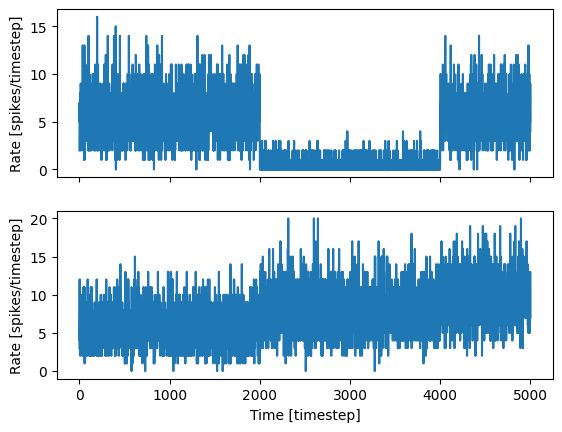

In [9]:
fig, axes = plt.subplots(2, sharex=True)

axes[0].plot(data)
axes[1].plot(data_bad)

axes[0].set_ylabel("Rate [spikes/timestep]")
axes[1].set_ylabel("Rate [spikes/timestep]")
axes[1].set_xlabel("Time [timestep]")